# K-Means Clustering Unsupervised Model
**Sites Used**\
[Scikit Learn KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)\
[NSL-KDD With KMeans](https://notebook.community/nickjmiller/KMeansNSL-KDD/kmeans)

In [1]:
# Import everything, define hyperparameters and features.
# Load the preprocessed data and apply variance threshold to it.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, classification_report
from sklearn.feature_selection import VarianceThreshold
from sklearn.utils import check_random_state
import joblib
from common_stage import prepareData

# Hyperparameters
hyperparams = {
    'k_clusters': 4,
    'max_iter': 100,
    'per_dist': 95,
    'variance_threshold': 0.02
}

# Features to be dropped
dropped_features = [
    'srv_count', 'srv_serror_rate', 'srv_rerror_rate',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate'
]

# Load and preprocess data
x_train, y_train, x_test, y_test = prepareData(scaling='minmax', removed_features=dropped_features)

# Apply variance threshold to remove low-variance features
selector = VarianceThreshold(hyperparams['variance_threshold'])
x_train = pd.DataFrame(selector.fit_transform(x_train), columns=x_train.columns[selector.get_support()])

print("Training model shape: ")
print(x_train.shape)

Training model shape: 
(493969, 15)


In [2]:
## Train K-Means on training data

kmeans = KMeans(n_clusters=hyperparams['k_clusters'], max_iter=hyperparams['max_iter'], random_state=42).fit(x_train)
x_train['cluster'] = kmeans.labels_

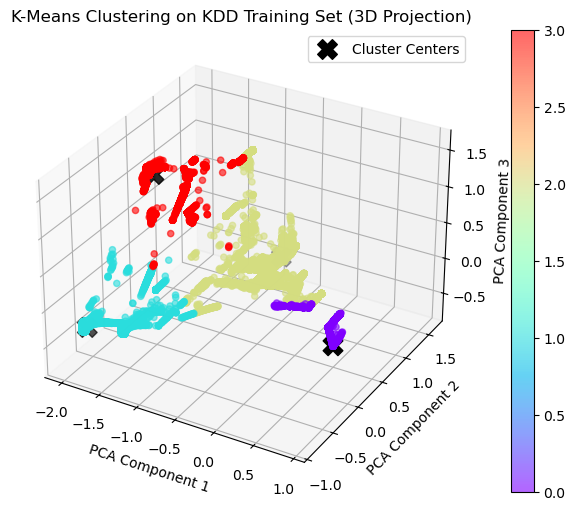

In [3]:
## Create a plot of the clusters in 3D using PCA

pca = PCA(n_components=3)
X_pca_train = pca.fit_transform(x_train.drop(columns=['cluster']))
# Transform cluster centers
centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=x_train.drop(columns=['cluster']).columns)
centers_pca = pca.transform(centers_df)
# Plot Clusters in 3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca_train[:, 0], X_pca_train[:, 1], X_pca_train[:, 2], c=x_train['cluster'], cmap='rainbow', alpha=0.6)
ax.scatter(centers_pca[:, 0], centers_pca[:, 1], centers_pca[:, 2], c='black', marker='X', s=200, label='Cluster Centers')
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
ax.set_title("K-Means Clustering on KDD Training Set (3D Projection)")
plt.legend()
plt.colorbar(scatter)
plt.show()

In [4]:
## Determine anomalous datapoints by analyzing distances
# - For all datapoints, transform gets the distances to their respcetive cluster centers.
# - Flag datapoints as anomalous if they are within the X% furthest away ones.

features = x_train.drop(columns=['cluster'])
distances = kmeans.transform(features)
x_train.head()

min_distances = np.min(distances, axis=1)
thresh = np.percentile(min_distances, hyperparams['per_dist'])  # % Farthest
x_train['anomaly'] = (min_distances > thresh).astype(int)

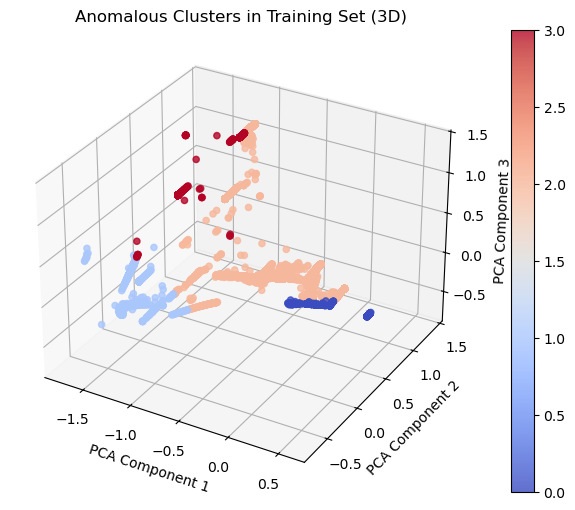

In [5]:
## Create a 3D plot to show the anomalous clusters

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
anomaly_mask = x_train['anomaly'] == 1
anomaly_pca = X_pca_train[anomaly_mask]
anomaly_clusters = x_train['cluster'][anomaly_mask]
anomaly_plot = ax.scatter(anomaly_pca[:, 0], anomaly_pca[:, 1], anomaly_pca[:, 2], c=anomaly_clusters, cmap='coolwarm', alpha=0.8)
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
ax.set_title("Anomalous Clusters in Training Set (3D)")
plt.colorbar(anomaly_plot)
plt.show()

In [6]:
## Get evaluation metrics specific for clustering.
# - Davies-Bouldin: Measures models performance by comparing the average similarity between the pairwise most similar clusters. Lower DBI is better.
# - Calinski-Harabasz Index: Compares the ratio of the between-cluster dispersion with the within-cluster dispersion. Higher CI is better.
# - Silhouette Score: Measues how well each data point is clustered by assessing its similarity to its own cluster compated to other clusters (the average).
#    Close to +1 indicates that the datapoint is well defined to its cluster. Negative means that the data point has been assigned to the wrong cluster.
#    And close to 0 suggets that the data point is close to the descision boundary of two clusters. It is not well defined.

sample_size = 5000
random_state = check_random_state(42)
sil_score = silhouette_score(features, x_train['cluster'], sample_size=sample_size, random_state=random_state)
dbi_score = davies_bouldin_score(features, x_train['cluster'])
ch_score = calinski_harabasz_score(features, x_train['cluster'])

print("Silhouette Score:", sil_score)
print("Davies-Bouldin Index:", dbi_score)
print("Calinski-Harabasz Index:", ch_score)

Silhouette Score: 0.8375927668063521
Davies-Bouldin Index: 0.5298301021967861
Calinski-Harabasz Index: 1165801.5325368687


In [7]:
## Create a Classification Report (Only part that uses y_test)

cluster_labels = x_train['cluster']
true_labels = y_train.reset_index(drop=True).astype(str)
mapped_labels = pd.Series(index=cluster_labels.index, dtype=str)
for cluster_id in cluster_labels.unique():
    cluster_indices = cluster_labels[cluster_labels == cluster_id].index
    dominant_label = true_labels.loc[cluster_indices].value_counts().idxmax()
    mapped_labels.loc[cluster_indices] = dominant_label
print("\n--USING LABLELLED DATA FRAMES--\nClassification Report (mapped clusters vs true labels):")
print(classification_report(true_labels, mapped_labels, zero_division=0))


--USING LABLELLED DATA FRAMES--
Classification Report (mapped clusters vs true labels):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    391458
           1       0.94      0.99      0.96     97278
           2       0.00      0.00      0.00      4107
           3       0.00      0.00      0.00      1126

    accuracy                           0.98    493969
   macro avg       0.48      0.50      0.49    493969
weighted avg       0.97      0.98      0.98    493969

